# 可用的完整的推理代码

In [57]:
import os
import cv2
import numpy as np
import sys
import subprocess
from datetime import datetime

sys.path.append('../')

import os
import uuid
from ffmpy import FFmpeg
import torchlm

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from models.LawDNet_new import LawDNet 
from collections import OrderedDict
import warnings 
from config.config import DINetInferenceOptions, DINetTrainingOptions
# from cfg import *
# from tools import *

from torchlm.tools import faceboxesv2
from torchlm.models import pipnet

# from torch_affine_ops import *
from tensor_processing import *
from Give_Yihao import extract_deepspeech

warnings.filterwarnings("ignore")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [58]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [59]:
def read_video_np(video_path):
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    H, W = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    print('video length: ', length)
    print('video size: ','H--', H, 'W--',W)
    
    frames = []
    frames_id = 1
    i = 0
    while True:
        ret, frame = cap.read()
        i = i + 1
        if ret:
            frames_id += 1 
            frames.append(frame)
        else:
            break
        
        if i == 800:
            break

    cap.release()
    return frames

# 加载预训练模型
## 320
- 常用路径：/home/dengjunli/data/dengjunli/autodl拿过来的/DINet-update/asserts/training_model_weight-标准框60关键点8/clip_training_256/netG_model_epoch_38.pth
### 注意修改关键点数量  和  standard_grid_size
### 关键点是5！！ standard_grid_size是60  训练时 mouth_size是256

## 360
- ../asserts/training_model_weight/clip_training_256/netG_model_epoch_60.pth
- /home/dengjunli/data/dengjunli/autodl拿过来的/DINet-update/asserts/training_model_weight-360分辨率正式模型备份/clip_training_256/netG_model_epoch_60.pth
### 关键点是5！！ standard_grid_size是60  训练时 mouth_size是288

In [60]:
deepspeech_model_path = "../asserts/output_graph.pb"
lawdnet_model_path = "../asserts/training_model_weight/clip_training_256/netG_model_epoch_60.pth" ## 固定参考帧训练的模型，标准框60关键点5
# lawdnet_model_path = "../asserts/training_model_weight-标准框60关键点8/clip_training_256/netG_model_epoch_38.pth" # 标准框，60 关键点5训练的模型
# lawdnet_model_path = "../asserts/training_model_weight-360分辨率正式模型备份/clip_training_256/netG_model_epoch_60.pth" # work！大嘴标准框，60关键点5训练的模型


# 公共设置


In [61]:
out_W = 320

## 填写输入的视频路径，填写输出的视频名称

In [62]:
video_path = '../asserts/training_data/split_video_25fps/RD_Radio34_000_corrected.mp4'
# video_path = './template/12月22日-meitu13头部.mp4'
output_name = '5kp-60standard—epoch60-720P-固定参考帧'
# 获取视频文件的名称，不包括扩展名
video_name = os.path.splitext(os.path.basename(video_path))[0]
# 将视频名称添加到output_name
output_name = f"{output_name}_{video_name}"

video_frames = read_video_np(video_path)
video_frames = np.array(video_frames, dtype=np.float32)
video_frames = video_frames[:, :, :, ::-1] # BGR to RGB
print(video_frames.shape)

video length:  698
video size:  H-- 1080 W-- 1920


(698, 1080, 1920, 3)


## 填写（driven audio 路径）或者 （deepspeech pt文件路径），模型路径

In [63]:
audio_path = './template/英文tts.wav'
# deepspeech_tensor,_ = extract_deepspeech(audio_path,deepspeech_model_path)
# torch.save(deepspeech_tensor, './template/中文tts.pt')
# deepspeech_tensor = torch.load('./template/test_chinese_wav_man_tts.pt')
deepspeech_tensor = torch.load('./template/英文tts.pt')

# 提取原声音频

In [64]:
# # # 提取原声视频
# res_audio_dir = './template'
# print('extract audio from video: {}'.format(os.path.basename(video_path)))
# audio_path = os.path.join(res_audio_dir, os.path.basename(video_path).replace('.mp4', '.wav'))
# # cmd = 'ffmpeg -y -i {} -f wav -ar 16000 {}'.format(video_path, audio_path)
# # subprocess.call(cmd, shell=True)
# deepspeech_tensor,_ = extract_deepspeech(audio_path,deepspeech_model_path)

# # 提前加载保存好的deepspeech
# torch.save(deepspeech_tensor, audio_path.replace('.wav','.pt'))
# deepspeech_tensor = torch.load(audio_path.replace('.wav','.pt'))

## 改变音频的通道数-供别的代码talklip使用（推理时不用）

In [65]:
# from scipy.io import wavfile
# import numpy as np

# # 读取wav文件
# audio_path = './template/WRA_JebHensarling0_000.wav'
# sample_rate, audio_data = wavfile.read(audio_path)

# # 获取通道数
# if len(audio_data.shape) == 1:
#     channels = 1  # 单通道（单声道）
# else:
#     channels = audio_data.shape[1]  # 多通道（如立体声）

# print(f"Sample Rate: {sample_rate} Hz")
# print(f"Channels: {channels}")

# # 检查是否为双声道
# if len(audio_data.shape) == 2 and audio_data.shape[1] == 2:
#     audio_mono = np.mean(audio_data, axis=1, dtype=audio_data.dtype)  # 平均左右通道
# else:
#     audio_mono = audio_data  # 如果已经是单声道，不需要更改

# # 只保留前40秒的音频
# audio_mono = audio_mono[:sample_rate*10]

# # 保存为单声道wav文件
# wavfile.write(audio_path.replace('.wav','_1_channel_10s.wav'), sample_rate, audio_mono)

## 填写并行化推理batch

In [66]:
# 
# batchsize 并行化推理
B = 50
len_out = (np.min([len(video_frames), deepspeech_tensor.shape[0]])//B)*B
video_frames = video_frames[:len_out]
deepspeech_tensor = deepspeech_tensor[:len_out]

# load model

In [67]:
# load model
# load model
# 手动为参数提供值
args = [
    '--source_channel', '3',
]
opt = DINetTrainingOptions().parse_args(args)

net_g = LawDNet(opt.source_channel,opt.ref_channel,opt.audio_channel).to(device)
checkpoint = torch.load(lawdnet_model_path) 
state_dict = checkpoint['state_dict']['net_g']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # remove module.
    new_state_dict[name] = v
net_g.load_state_dict(new_state_dict)
net_g.eval()
facealigner = FaceAlign(ratio=1.6, device=device)
# sqmasker = SmoothSqMask(radius=30,sigma=10,standard_shape=(416,320),padding='same')
sqmasker = SmoothSqMask().cuda()

#### landmark 提取 ，用于原视频的正脸化

In [68]:
from tqdm import tqdm

#### landmark
torchlm.runtime.bind(faceboxesv2(device=device))  # set device="cuda" if you want to run with CUDA
# set map_location="cuda" if you want to run with CUDA
torchlm.runtime.bind(
  pipnet(backbone="resnet18", pretrained=True,  
         num_nb=10, num_lms=68, net_stride=32, input_size=256,
         meanface_type="300w", map_location=device.__str__(), checkpoint=None) 
) # will auto download pretrained weights from latest release if pretrained=True
landmarks,_ = torchlm.runtime.forward(video_frames[0])

landmarks_list = []

for i in tqdm(range(len(video_frames)), desc="提取landmark"):
    landmarks, bboxes = torchlm.runtime.forward(video_frames[i])
    trust = bboxes[:,4]
    faithful_index = np.argsort(trust)[-1]
    landmarks_list.append(landmarks[faithful_index,:,:])

landmarks_list = np.array(landmarks_list)

提取landmark: 100%|██████████| 400/400 [00:58<00:00,  6.81it/s]


# 有一个修改分辨率的参数请注意
### 增大嘴部时：
- 模型：/home/dengjunli/data/dengjunli/autodl拿过来的/DINet-update/asserts/training_model_weight-标准框60关键点8/clip_training_256/netG_model_epoch_38.pth
- out_W = 360
- size = 468 360

## 不增大嘴部时：
- out_W = 320
- 模型：../asserts/training_model_weight/clip_training_256/netG_model_epoch_60.pth
- size = 416 320


## 提取随机参考帧

In [69]:
# # uniform reference from random 5 frames
# reference_index = torch.randint(0, len(video_frames), (5,)).tolist()
# # reference_index = [6,0,0,0,0]
# reference_tensor = torch.from_numpy(video_frames[reference_index]).to(device)
# reference_tensor = reference_tensor.permute(0,3,1,2)
# reference_landmarks = torch.from_numpy(landmarks_list[reference_index]).to(device)
# reference_tensor,_,_ = facealigner(reference_tensor, reference_landmarks,out_W=out_W) # 修改分辨率时切记此参数！！！！！
# plt.imshow(reference_tensor[0].permute(1,2,0).cpu().numpy().astype(np.uint8))
# reference_tensor = reference_tensor/255.0
# print("reference_tensor.shape:",reference_tensor.shape)
# plt.axis('off')
# plt.savefig('生成图source_img.png',bbox_inches='tight', pad_inches=0)

# 获取固定口型的参考帧


reference_tensor.shape: torch.Size([5, 3, 416, 320])


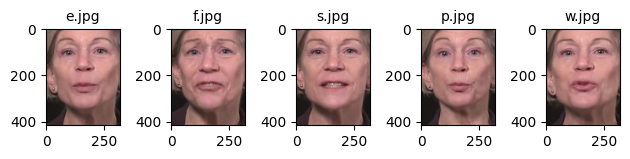

In [70]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Image file names
image_filenames = ['e.jpg', 'f.jpg', 's.jpg', 'p.jpg', 'w.jpg']
# Base path to the images
base_path = '../asserts/training_data/split_video_25fps_crop_face/RD_Radio34_000_corrected/'

# Initialize the list to hold the reference tensors
reference_tensors = []

# Loop through each image file
for filename in image_filenames:
    # Load the image
    image_path = os.path.join(base_path, filename)
    image = Image.open(image_path).convert('RGB')
    
    # Convert the image to a numpy array and then to a tensor
    image_tensor = torch.from_numpy(np.array(image)).to(device)
    
    # Rearrange the tensor dimensions to be in the (C, H, W) format
    image_tensor = image_tensor.permute(2, 0, 1)
    
    # Add the image tensor to the reference tensors list
    reference_tensors.append(image_tensor)

# Stack all reference tensors to create a batch
reference_tensor = torch.stack(reference_tensors).cuda().float() / 255.0

# Insert loading landmarks_list
# reference_landmarks = load corresponding landmarks for the images here

# Align faces based on landmarks
# reference_tensor, _, _ = facealigner(reference_tensor, reference_landmarks, out_W=out_W)  # 修改分辨率时切记此参数！！！！！

out_W = out_W  # 目标宽度
aspect_ratio = reference_tensor.shape[2] / reference_tensor.shape[3]  # 假设所有图像具有相同的宽高比
out_H = int(out_W * aspect_ratio)  # 根据宽度计算高度以保持等比例

print("reference_tensor.shape:", reference_tensor.shape)

# 使用 torch.nn.functional.interpolate 对整个批次进行缩放
# resized_tensors = F.interpolate(reference_tensor.cuda().float(), size=(out_H, out_W), mode='bilinear', align_corners=False)


# plt.imshow((reference_tensor[0]*255).permute(1, 2, 0).cpu().numpy().astype(np.uint8))

## 设置图像显示的大小
# plt.figure(figsize=(15, 3))  # 设置足够宽以容纳五张图像

# 遍历五张图像的张量
for i in range(len(reference_tensors)):
    plt.subplot(1, 5, i + 1)  # 创建子图(1行5列)
    img = (reference_tensors[i]).permute(1, 2, 0).cpu().numpy().astype(np.uint8)  # 将张量转换为图像格式
    plt.imshow(img)  # 显示图像(需要将RGB转换为BGR)
    plt.title(image_filenames[i], fontsize=10)  # 为每张图像设置标题，使用对应的文件名
    # plt.axis('off')  # 隐藏坐标轴

plt.tight_layout()  # 调整子图间距
plt.show()  # 显示图像


In [71]:
def reference(model,masked_source,reference,audio_tensor):
    with torch.no_grad():
        output = model(masked_source,reference,audio_tensor)
        return output

# 有一个修改分辨率的参数请注意
### 增大嘴部时：
- 模型：/home/dengjunli/data/dengjunli/autodl拿过来的/DINet-update/asserts/training_model_weight-标准框60关键点8/clip_training_256/netG_model_epoch_38.pth
- out_W = 320
- size = 416 320

## 不增大嘴部时：
- out_W = 360
- 模型：/home/dengjunli/data/dengjunli/autodl拿过来的/DINet-update/asserts/training_model_weight-360分辨率正式模型备份/clip_training_256/netG_model_epoch_60.pth
- size = 486 360

### B设为50时，4090显存占23G，10秒钟能出50帧，超实时效果

处理批次:   0%|          | 0/8 [00:00<?, ?it/s]

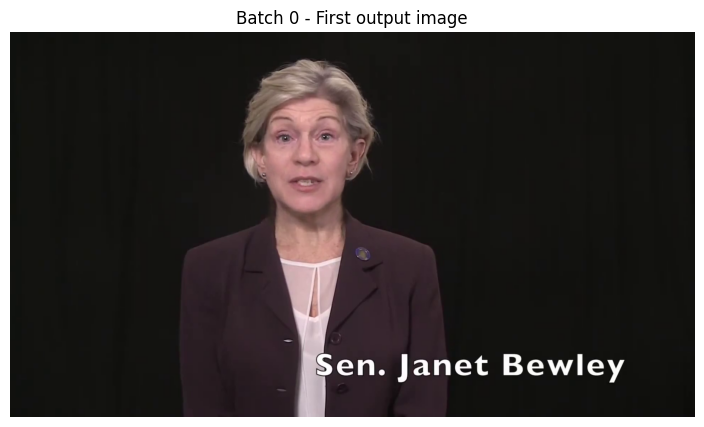

处理批次: 100%|██████████| 8/8 [00:37<00:00,  4.64s/it]


In [72]:
visualize_every_n_batches = 30  # 在每30个批次后进行一次可视化
outframes = np.zeros_like(video_frames)

for i in tqdm(range(len_out // B), desc="处理批次"):
    source_tensor = torch.from_numpy(video_frames[i*B:(i+1)*B].copy()).to(device)
    source_tensor = source_tensor.permute(0,3,1,2)
    landmarks_tensor = torch.from_numpy(landmarks_list[i*B:(i+1)*B]).to(device)
    feed_tensor,_,affine_matrix = facealigner(source_tensor, landmarks_tensor,out_W=out_W) # # 修改分辨率时切记此参数！！！！
    _,C,H,W = feed_tensor.shape

    feed_tensor_masked = sqmasker(feed_tensor)

    reference_tensor_B = reference_tensor.unsqueeze(0).repeat(B,1,1,1,1).view(B,5*3,H,W)

    audio_tensor = deepspeech_tensor[i*B:(i+1)*B].to(device)

    output_B = reference(net_g,feed_tensor_masked/255.0,reference_tensor_B,audio_tensor)
    # covert half into float
    output_B = output_B.float().clamp_(0,1)
    # recover
    outframes_B = facealigner.recover(output_B*255.0,source_tensor,affine_matrix)

    outframes_B = outframes_B.permute(0,2,3,1).cpu().numpy().astype(np.uint8)

    outframes[i*B:(i+1)*B] = outframes_B

        # 在指定的批次进行可视化
    if i % visualize_every_n_batches == 0:
        # 假设 outframes_B 包含了 B 个输出图像, 我们取第一个进行展示
        image_to_show = outframes_B[0]

        # 绘制图像
        plt.figure(figsize=(10, 5))
        plt.imshow(image_to_show)
        plt.title(f"Batch {i} - First output image")
        plt.axis('off')
        plt.show()
    

In [73]:
reference_tensor.shape

torch.Size([5, 3, 416, 320])

In [74]:
# print(reference_tensor.shape)
# print(reference_tensor_B.shape)

# for i in range(reference_tensor.shape[0]):
#     cv2.imwrite("参考帧"+str(i)+".jpg",(reference_tensor[i]*255.0).permute(1,2,0).cpu().numpy().astype(np.uint8)[:,:,::-1])

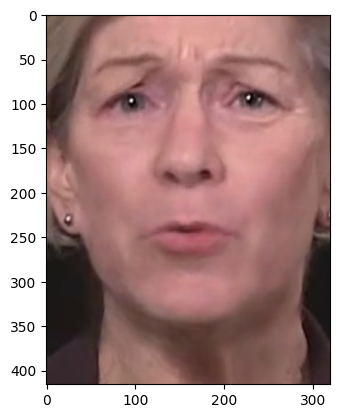

In [75]:
plt.imshow((output_B[1]*255.0).permute(1,2,0).cpu().numpy().astype(np.uint8))
# plt.imshow(outframes[0]/255.0)
# plt.axis('off')
# plt.savefig('真-生成图source_img.png',bbox_inches='tight', pad_inches=0)

In [76]:
outframes = outframes.astype(np.uint8) 
outframes = outframes[:,:,:,::-1] # RGB to BGR


In [77]:
# export video
timestamp_str = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = './output_'+timestamp_str+'.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
videoWriter = cv2.VideoWriter(output_path, fourcc, 25, (video_frames.shape[2],video_frames.shape[1]),True)
for i in range(len_out):
    videoWriter.write(outframes[i])
videoWriter.release()

In [78]:
output_path

'./output_20240305_041825.mp4'

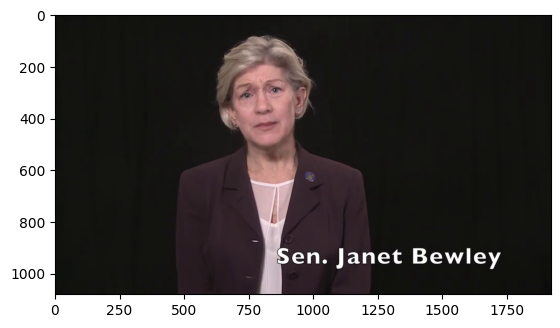

In [79]:
plt.imshow(outframes[i][:,:,::-1])

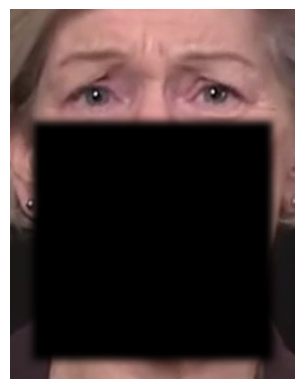

In [80]:
plt.imshow(feed_tensor_masked[6].permute(1,2,0).cpu().numpy().astype(np.uint8))
# 关闭坐标轴
plt.axis('off')
plt.savefig('遮罩source_img.png',bbox_inches='tight', pad_inches=0)

In [81]:
feed_tensor_masked.shape

torch.Size([50, 3, 416, 320])

In [82]:

# 视频添加音频
def video_add_audio(video_path: str, audio_path: str, output_dir: str):
    _ext_video = os.path.basename(video_path).strip().split('.')[-1]
    _ext_audio = os.path.basename(audio_path).strip().split('.')[-1]
    if _ext_audio not in ['mp3', 'wav']:
        raise Exception('audio format not support')
    _codec = 'copy'
    if _ext_audio == 'wav':
        _codec = 'aac'
    result = os.path.join(
        output_dir, '{}.{}'.format(
            video_path.replace(".mp4",output_name), _ext_video))
    ff = FFmpeg(
        inputs={video_path: None, audio_path: None},
        outputs={result: '-map 0:v -map 1:a -c:v copy -c:a {} -shortest'.format(_codec)})
    print(ff.cmd)
    ff.run()
    return result

In [83]:
video_add_audio(output_path, audio_path , './')

ffmpeg -i ./output_20240305_041825.mp4 -i ./template/英文tts.wav -map 0:v -map 1:a -c:v copy -c:a aac -shortest ././output_20240305_0418255kp-60standard—epoch60-720P-固定参考帧_RD_Radio34_000_corrected.mp4


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/dengjunli/miniconda3 --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.

'././output_20240305_0418255kp-60standard—epoch60-720P-固定参考帧_RD_Radio34_000_corrected.mp4'